#### Pendientes

In [1]:
#TODO 1: Revisar si las distribuciones vienen de una normal (CHECK)
#TODO 2: Revisar si estas diferencias son stadisticamente significativas (CHECK)
#TODO 3: Quitar las stopwords y revisar si se mantiene esta distribucion (CHECK)
#TODO 4: Si la distribucion no se mantiene, mantener pronombres en los stopwords ("CHECK")
#TODO 5: sacar caracteristicas TFIDF 
#TODO 6: Entrenar 3 modelos con esas caracteristicas XGBoost,LightGBM, Logistic Regression
#TODO 7: Sacar caracteristicas con BERT
#TODO 8: Entrenar 3 modelos con esas caracteristicas XGBoost,LightGBM, Logistic Regression
#TODO 9: realizar clasificacion explicita con 2 LLMs, pre-entrenadas y sin pre-entreno
#TODO 10: Comparar resultados
#TODO 11: Corroorar hallazgos con la literatura

#### Config & Data ingestion

In [2]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation
import re
import statsmodels.api as sm 
from scipy.stats import mannwhitneyu
from scipy import stats
import spacy 
from parallel_pandas import ParallelPandas
import polars as pl
from collections import Counter




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\franc\miniconda3\envs\tesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#initialize parallel-pandas
ParallelPandas.initialize(n_cpu=16, split_factor=4, disable_pr_bar=False)

In [4]:
#Functions definition 

def remove_stopwords(text, stopwords):
    return " ".join([word for word in str(text).split() if word not in stopwords])

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))



In [5]:
sns.set_theme(style ="ticks",context="paper", rc={'figure.figsize':(8,4)})


In [6]:
#Data Imports
data_path = Path(os.getcwd()).parent / "data"
train_path = data_path / "bronze" / "dreaddit-train.csv"
test_path = data_path / "bronze" / "dreaddit-test.csv"

train = pd.read_csv(train_path)
test =  pd.read_csv(test_path)
df = pd.concat([train,test]).reset_index(drop=True)

In [7]:

print(f"There are {df.shape[0]} entries")
print(f"Dataset have {df.shape[1]} features")

There are 3553 entries
Dataset have 116 features


There is a confirmation that labels are balanced


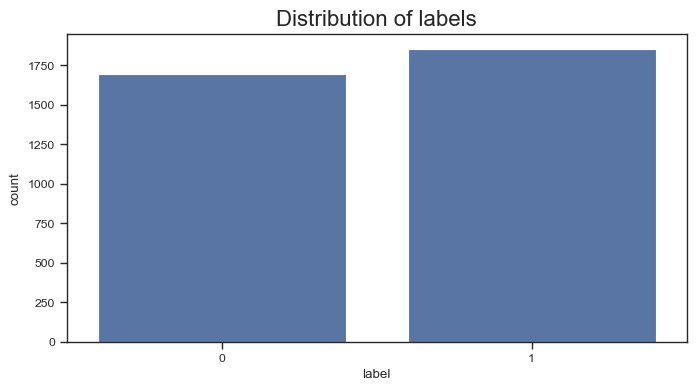

In [8]:
ax= sns.barplot(df.value_counts("label").reset_index(), x="label", y="count")
ax.set_title('Distribution of labels', fontsize=16)
print("There is a confirmation that labels are balanced")


#### Data Cleaning/ Initial Data wrangling


In [9]:
#df["text"] = df.text.str.lower().apply(remove_punctuation).str.strip()
nlp = spacy.load("en_core_web_sm")
singular_pronouns = ["i", "you", "he","she","it ", "me", "him","her", "my","mine",
                     "your","yours", "his","her", "hers", "its","myself"]
plural_pronouns = ["we", "they", "us","them", "our", "ours", "their","theirs"]
#stop = nlp.Defaults.stop_words
stop = [x for x in nlp.Defaults.stop_words if x not in singular_pronouns and x not in plural_pronouns]

In [10]:
def clean_text(text, stopwords):
    doc=nlp(text.lower())
    txt_tokens = [token.lemma_ for token in doc if token.is_punct !=True and token.text not in stopwords]
    return txt_tokens

In [11]:
df["text_clean"] = df["text"].apply(clean_text,args= (stop,))


#### **Uso de lenguage en singular entre los labels**

¿Los casos positivos para ansiedad tienen un mayor uso de pronombres en sigular?

In [12]:
def flatten_comprehension(matrix):
     return [item for row in matrix for item in row]


In [13]:
mostCommonStress = Counter(flatten_comprehension(df.query("label ==1")["text_clean"].to_list())).most_common(1000)
mostCommonNoStress =Counter(flatten_comprehension(df.query("label ==0")["text_clean"].to_list())).most_common(1000)

In [14]:
def word_freq_to_df(mostCommonTuple):
    tmp1 = [x[0] for x in mostCommonTuple]
    tmp2 = [x[1] for x in mostCommonTuple]
    return pd.DataFrame({"words":tmp1, "freq":tmp2})


In [15]:
mostCommonStress = word_freq_to_df(mostCommonStress)
mostCommonNoStress = word_freq_to_df(mostCommonNoStress)

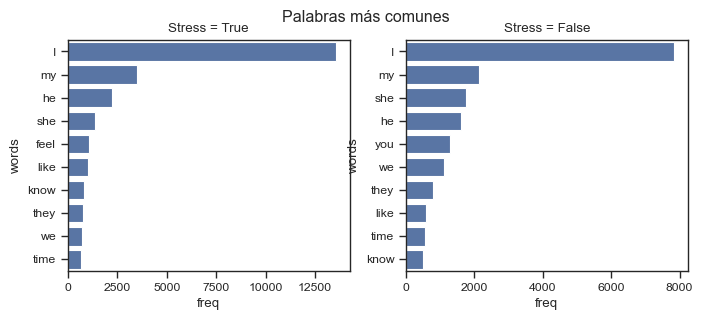

In [16]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
fig.suptitle("Palabras más comunes ")
ax1 = sns.barplot(data=mostCommonStress[:10],x="freq", y="words", ax=axes[0])
ax1.set_title("Stress = True")
ax2 = sns.barplot(data=mostCommonNoStress[:10],x="freq", y="words", ax=axes[1])
ax2.set_title("Stress = False");


In [17]:
singularStress = mostCommonStress[mostCommonStress.words.isin(singular_pronouns)]
singularNoStress = mostCommonNoStress[mostCommonNoStress.words.isin(singular_pronouns)]

pluralStress = mostCommonStress[mostCommonStress.words.isin(plural_pronouns)]
pluralNoStress = mostCommonNoStress[mostCommonNoStress.words.isin(plural_pronouns)]

In [18]:
def count_words(words, subset):
    count=0
    for item in subset:
        count+= words.count(item)
    return count   


In [19]:
df["count_singular"] = df["text_clean"].apply(count_words,args=(singular_pronouns,))
df["count_plural"] = df["text_clean"].apply(count_words,args=(plural_pronouns,))

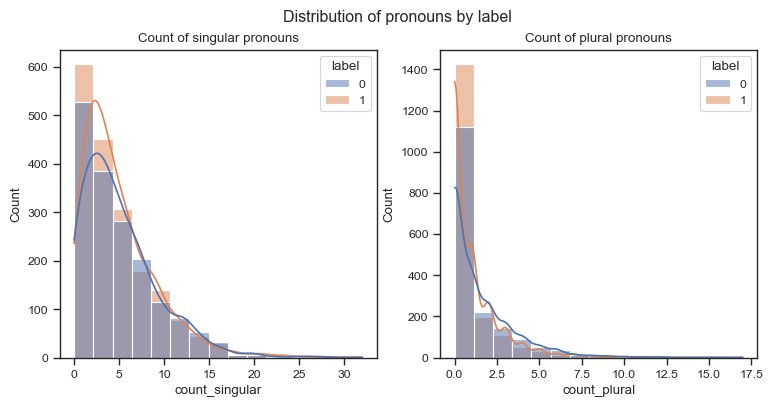

In [20]:
fig, axes = plt.subplots(1,2, figsize=(9,4))
fig.suptitle("Distribution of pronouns by label")
ax1 = sns.histplot(df,x="count_singular", bins=15,hue="label", kde=True, ax=axes[0])
ax1.set_title("Count of singular pronouns")
ax2 =sns.histplot(df,x="count_plural", bins=15,hue="label", kde=True, ax=axes[1])
ax2.set_title("Count of plural pronouns");

In [21]:
#cloud_stress=WordCloud(background_color='pink',).generate(" ".join(df.query("label ==1").text.values))
#cloud_noStress=WordCloud().generate(" ".join(df.query("label ==0").text.values))

#plt.subplot(1,2,1)
#plt.axis('off')
#plt.imshow(cloud_stress)

#plt.subplot(1,2,2)
#plt.axis('off')
#plt.imshow(cloud_noStress)

#cloud_stress=WordCloud(background_color='pink',).generate(" ".join(df.query("label ==1").text_clean.values))
#cloud_noStress=WordCloud().generate(" ".join(df.query("label ==0").text_clean.values))

#plt.subplot(1,2,1)
#plt.axis('off')
#plt.imshow(cloud_stress)

#plt.subplot(1,2,2)
#plt.axis('off')
#plt.imshow(cloud_noStress)

En un principio parece ser que no son diferentes, sin embargo, es necesario realizar una prueba estadistica para confirmarlo.

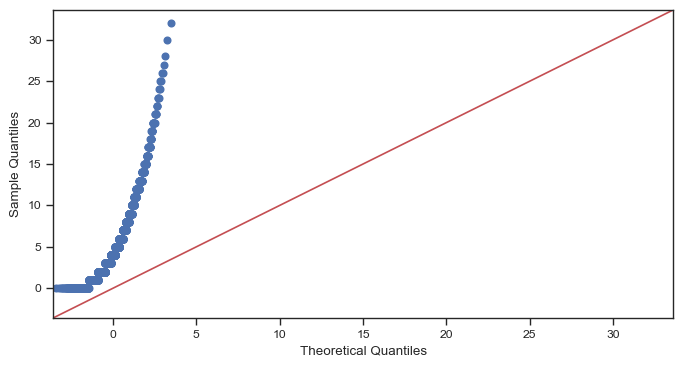

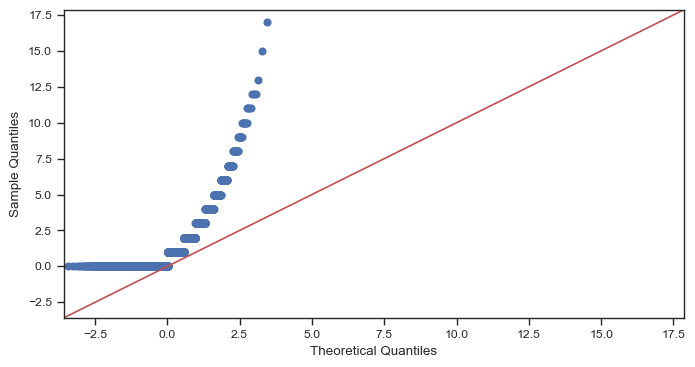

In [22]:
sm.qqplot(df.count_singular, line ='45');
sm.qqplot(df.count_plural, line ='45');

Se comprueba que las distribuciones NO son normales, por lo tanto, se deben usar pruebas no paramétricas para compararlas, 

In [23]:
singularPronounsStress = df.query("label==1").count_singular
singularPronounsNoStress = df.query("label==0").count_singular

#pluralPronounsStress = df.query("label==1").count_plural
#pluralPronounsNoStress = df.query("label==0").count_plural

U, p_singular = mannwhitneyu(singularPronounsStress, singularPronounsNoStress)
#U, p_plural = mannwhitneyu(pluralPronounsStress, pluralPronounsNoStress)

print(f"P-value para pronombres singulares: {p_singular}")
#print(f"P-value para pronombres plurales: {p_plural}")

P-value para pronombres singulares: 0.3142573050368609


In [24]:
"two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical."

'two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.'

In [25]:
#singularPronounsStress = df.query("label==1").count_singular
#singularPronounsNoStress = df.query("label==0").count_singular

#pluralPronounsStress = df.query("label==1").count_plural
#pluralPronounsNoStress = df.query("label==0").count_plural

#U, p_singular = stats.kstest(singularPronounsStress, singularPronounsNoStress)
#U, p_plural = stats.kstest(pluralPronounsStress, pluralPronounsNoStress)
#KS solo usa datos continuos, probablemente no se aplica en este caso (resultados contrarios a mann whitney cuando es one sided)
#print(f"P-value para pronombres singulares: {p_singular}")
#print(f"P-value para pronombres plurales: {p_plural}")

El test estadistico nos comprueba que la distribucion de pronombres usados por personas con estres y sin estres es similar. Indicando que el uso de pronombres singulares por personas estresadas no difiere mucho del uso de personas no estresadas, esto no va acorde a la literatura, sin emabargo se explica dado que los estudios se realizaron con personas con trastornos mentales de diferente indole (depresion, ansiedad). 

,subreddit,id,text,label,text_clean
0,ptsd,33181,"He said he had not felt that way before, sugge...",1,"[he, say, he, feel, way, suggete, I, rest, tri..."
1,assistance,2606,"Hey there r/assistance, Not sure if this is th...",0,"[hey, r, assistance, sure, right, place, post,..."
2,ptsd,38816,My mom then hit me with the newspaper and it s...,1,"[my, mom, hit, I, newspaper, shock, I, she, sh..."
3,relationships,239,"until i met my new boyfriend, he is amazing, h...",1,"[I, meet, my, new, boyfriend, he, amazing, he,..."
4,survivorsofabuse,1421,October is Domestic Violence Awareness Month a...,1,"[october, domestic, violence, awareness, month..."
...,...,...,...,...,...
3548,ptsd,24271,i have horrible vivid nightmares every night. ...,1,"[I, horrible, vivid, nightmare, night, they, t..."
3549,relationships,2212,Also I can't think about both of them without ...,1,"[I, think, they, get, angry, jealous, talk, th..."
3550,relationships,27951,"Furthermore, I told him before we got really s...",1,"[furthermore, I, tell, he, we, get, I, anxiety..."
3551,assistance,1164,Here's the link to my amazon wish list where t...,0,"[link, my, amazon, wish, list, item, <, url, >..."


In [30]:
output_path = data_path / "silver" / "dreaddit_data_clean.csv"
df[["subreddit","id","text","label","text_clean"]].to_csv(output_path, index=False)